<h1>Trying XGBoost and SHAP to Prepare for Super Computer</h1>

In [65]:
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from jeffutils.utils import movecol
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Read in the data
df = pd.read_feather('data/dylan_data/play_by_play_full_state_space.feather')
df = df.loc[:, ~df.columns.str.contains('_raw')]
df.head()

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,0,1200.0,0,3600,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0,Toronto Maple Leafs,home,REGULAR,1,69,1131.0,69,3531,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,73,1127.0,73,3527,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,86,1114.0,86,3514,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0,Montréal Canadiens,away,REGULAR,1,91,1109.0,91,3509,0,0,3.0,2.0,5v5,EV,Even,-,False,5,5,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0


In [3]:
# Get only the rows with game_date >= 2021-10-01
df_last_two = df[df['game_date'] >= '2021-10-01']

# Create win column
df_last_two['win'] = (df_last_two['home_final'] > df_last_two['away_final']).astype(int)

# Drop columns we do not need for XGBoost
df_last_two.drop(columns=['game_date', 'date_time', 'game_id', 'home_name', 'away_name',
                          'event_type', 'penalty_severity', 'penalty_minutes', 'event_team',
                          'event_team_type', 'period_type', 'period', 'period_seconds',
                          'period_seconds_remaining', 'game_seconds', 'home_final', 'away_final',
                          'strength_state', 'strength', 'empty_net',
                          'extra_attacker', 'home_skaters', 'away_skaters', 'order',
                          ], inplace=True)

# One hot encode stregnth_code
df_last_two = pd.get_dummies(df_last_two, columns=['strength_code'], drop_first=True)

# Get the X and y
X = df_last_two.drop(columns=['win'])
y = df_last_two['win']

In [4]:
# Create a DMatrix
dtrain = xgb.DMatrix(X, y, feature_names=X.columns)

params = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "hist",
}

# Train the model
xgb.set_config(verbosity=1)
model = xgb.train(params, dtrain, num_boost_round=50) 

print('Done with train.')

# Create the explainer
shap_values = model.predict(dtrain, pred_contribs=True)
print('Done with model predict.')
explainer = shap.TreeExplainer(model)
print('Done with explainer.')
shap_values = explainer.shap_values(X)
print('Done with shap_values.')

# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X[0, :],
    feature_names=X.columns,
    matplotlib=True,
)

# Show a summary of feature importance
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=X.columns)

Done with train.
Done with model predict.
Done with explainer.


<h1>Creating Code for XGBoost on Super Computer</h1>

In [103]:
# Read in the data
df = pd.read_feather('data/dylan_data/play_by_play_full_state_space.feather')
df = df.loc[:, ~df.columns.str.contains('_raw')]

df['home_name'] = df['home_name'].replace({'Montréal Canadiens': 'Montreal Canadiens',
                                           'MontrÃ©al Canadiens': 'Montreal Canadiens'})
df['away_name'] = df['away_name'].replace({'Montréal Canadiens': 'Montreal Canadiens',
                                             'MontrÃ©al Canadiens': 'Montreal Canadiens'})

# Get only the rows with game_date >= 2021-10-01
df_last_two = df[df['game_date'] >= '2021-10-01']

# Create win column
df_last_two['win'] = (df_last_two['home_final'] > df_last_two['away_final']).astype(int)

# Drop columns we do not need for XGBoost
df_last_two.drop(columns=['game_date', 'date_time',
                          'event_type', 'penalty_severity', 'penalty_minutes', 'event_team',
                          'event_team_type', 'period_type', 'period', 'period_seconds',
                          'period_seconds_remaining',
                          'strength_state', 'strength', 'empty_net',
                          'extra_attacker', 'home_skaters', 'away_skaters', 'order',
                          ], inplace=True)

df_last_two

,game_id,home_name,away_name,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_code,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME,win
2886906,2021020001,Tampa Bay Lightning,Pittsburgh Penguins,0,3600,0,0,2.0,6.0,EV,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2886907,2021020001,Tampa Bay Lightning,Pittsburgh Penguins,38,3562,0,0,2.0,6.0,EV,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2886908,2021020001,Tampa Bay Lightning,Pittsburgh Penguins,63,3537,0,0,2.0,6.0,EV,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2886909,2021020001,Tampa Bay Lightning,Pittsburgh Penguins,63,3537,0,0,2.0,6.0,EV,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2886910,2021020001,Tampa Bay Lightning,Pittsburgh Penguins,78,3522,0,0,2.0,6.0,EV,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2023021072,Vancouver Canucks,Washington Capitals,3555,45,1,2,1.0,2.0,PP,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6,0
3712182,2023021072,Vancouver Canucks,Washington Capitals,3585,15,1,2,1.0,2.0,PP,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6,0
3712183,2023021072,Vancouver Canucks,Washington Capitals,3586,14,1,2,1.0,2.0,PP,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6,0
3712184,2023021072,Vancouver Canucks,Washington Capitals,3587,13,1,2,1.0,2.0,PP,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6,0


In [104]:
unique_teams = df_last_two['home_name'].unique()

team_one = unique_teams[0]

# Get a subset of the data that just has team_one
df_team_one = df_last_two[(df_last_two['home_name'] == team_one) | (df_last_two['away_name'] == team_one)]

# Create a new column called 'opponent' that is the name of the team that team_one is playing
df_team_one['opponent'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_name'], df_team_one['home_name'])

# Create a new column if the selected team is the home team or not
df_team_one['is_home'] = (df_team_one['home_name'] == team_one).astype(int)
df_team_one['team'] = team_one

# Get the scored goals for the selected team
df_team_one['final_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_final'], df_team_one['away_final'])

# Get the scored goals for the opponent
df_team_one['final_opponent_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_final'], df_team_one['home_final'])

# Get the current scored goals for the selected team and the opponent
df_team_one['curr_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_score'], df_team_one['away_score'])
df_team_one['curr_opponent_goals'] = np.where(df_team_one['home_name'] == team_one, df_team_one['away_score'], df_team_one['home_score'])

# Create home and away strength codes
df_team_one['home_strength_code'] = df_team_one['strength_code']
df_team_one['away_strength_code'] = 'EV'
df_team_one.loc[df_team_one['home_strength_code'] == 'SH', 'away_strength_code'] = 'PP'
df_team_one.loc[df_team_one['home_strength_code'] == 'PP', 'away_strength_code'] = 'SH'

# Get the current strength code for the selected
df_team_one['curr_strength_code'] = np.where(df_team_one['home_name'] == team_one, df_team_one['home_strength_code'], df_team_one['away_strength_code'])

# Get if the selected team won or not
# df_team_one.drop(columns=['home_final', 'away_final', win], inplace=True)
df_team_one['win'] = (df_team_one['final_goals'] > df_team_one['final_opponent_goals']).astype(int)
df_team_one = movecol(df_team_one, ['team', 'opponent', 'is_home', 'curr_strength_code', 'curr_goals', 'curr_opponent_goals', 'win'], 'strength_code', 'Before')

# Drop a bunch of columns
df_team_one.drop(columns=['home_score', 'away_score', 'home_final', 'away_final', 'home_name', 'away_name', 'strength_code',
                          'final_goals', 'final_opponent_goals', 'home_strength_code', 'away_strength_code'], inplace=True)

# Get all columns with 'STATE_'
state_columns_pre = df_team_one.columns[df_team_one.columns.str.contains('STATE_')]
state_columns = list(set(["_".join(state.split('_')[:-1]) for state in state_columns_pre]))
sorted(state_columns)

# Iterate through each state getting the appropriate value for the selected team.
for state in state_columns:
    df_team_one[f"team_{state}"] = np.where(df_team_one['is_home'] == 1, df_team_one[f'{state}_HOME'], df_team_one[f'{state}_AWAY'])

# Iterate through each state getting the appropriate value for the opponent.
for state in state_columns:
    df_team_one[f"opponent_{state}"] = np.where(df_team_one['is_home'] == 1, df_team_one[f'{state}_AWAY'], df_team_one[f'{state}_HOME'])    

# Drop state_columns_pre
df_team_one.drop(columns=state_columns_pre, inplace=True)

# one hot opponent
df_team_one['opp'] = df_team_one['opponent']
df_team_one = pd.get_dummies(df_team_one, columns=['opponent'])

# one hot strength_code
df_team_one = pd.get_dummies(df_team_one, columns=['curr_strength_code'], drop_first=True)

# Get X and y
X = df_team_one.drop(columns=['game_id', 'team', 'win', 'opp'])
y = df_team_one['win']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
dtest = xgb.DMatrix(X_test, y_test, feature_names=X.columns)

# Train the model
params = params = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "hist",
    "device": 'cuda'
}
model = XGBClassifier(**params).fit(X_train, y_train)
# model = xgb.train(params, dtrain, num_boost_round=100)

# Evaluate the model
y_pred = model.predict_proba(X_test)

# See how well the model did
y_pred



[16:15:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:15:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[0.9868035 , 0.01319653],
       [0.08436394, 0.91563606],
       [0.06371093, 0.9362891 ],
       ...,
       [0.15444505, 0.84555495],
       [0.92858624, 0.07141374],
       [0.00531989, 0.9946801 ]], dtype=float32)

In [90]:
df_team_one

,game_id,game_seconds_remaining,team,is_home,curr_goals,curr_opponent_goals,win,team_STATE_GOAL,team_STATE_FACEOFF,team_STATE_GIVEAWAY,team_STATE_SHOT,team_STATE_BLOCKED_SHOT,team_STATE_TAKEAWAY,team_STATE_MISSED_SHOT,team_STATE_PENALTY,opponent_STATE_GOAL,opponent_STATE_FACEOFF,opponent_STATE_GIVEAWAY,opponent_STATE_SHOT,opponent_STATE_BLOCKED_SHOT,opponent_STATE_TAKEAWAY,opponent_STATE_MISSED_SHOT,opponent_STATE_PENALTY,opp,opponent_Anaheim Ducks,opponent_Arizona Coyotes,opponent_Boston Bruins,opponent_Buffalo Sabres,opponent_Calgary Flames,opponent_Carolina Hurricanes,opponent_Chicago Blackhawks,opponent_Colorado Avalanche,opponent_Columbus Blue Jackets,opponent_Dallas Stars,opponent_Detroit Red Wings,opponent_Edmonton Oilers,opponent_Florida Panthers,opponent_Los Angeles Kings,opponent_Minnesota Wild,opponent_Montreal Canadiens,opponent_Nashville Predators,opponent_New Jersey Devils,opponent_New York Islanders,opponent_New York Rangers,opponent_Ottawa Senators,opponent_Philadelphia Flyers,opponent_Pittsburgh Penguins,opponent_San Jose Sharks,opponent_Seattle Kraken,opponent_St. Louis Blues,opponent_Toronto Maple Leafs,opponent_Vancouver Canucks,opponent_Vegas Golden Knights,opponent_Washington Capitals,opponent_Winnipeg Jets,curr_strength_code_PP,curr_strength_code_SH
2886906,2021020001,3600,Tampa Bay Lightning,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Pittsburgh Penguins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2886907,2021020001,3562,Tampa Bay Lightning,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Pittsburgh Penguins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2886908,2021020001,3537,Tampa Bay Lightning,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,Pittsburgh Penguins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2886909,2021020001,3537,Tampa Bay Lightning,1,0,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,Pittsburgh Penguins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2886910,2021020001,3522,Tampa Bay Lightning,1,0,0,0,0,1,0,1,0,1,0,0,0,2,0,0,0,0,0,0,Pittsburgh Penguins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710166,2023021063,24,Tampa Bay Lightning,0,5,3,1,5,37,15,11,11,2,11,9,3,32,13,47,16,13,13,7,Florida Panthers,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3710167,2023021063,7,Tampa Bay Lightning,0,5,3,1,5,37,15,11,11,2,11,9,3,32,13,47,16,13,13,8,Florida Panthers,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3710168,2023021063,7,Tampa Bay Lightning,0,5,3,1,5,37,15,11,11,2,11,10,3,32,13,47,16,13,13,8,Florida Panthers,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3710169,2023021063,7,Tampa Bay Lightning,0,5,3,1,5,37,15,11,11,2,11,10,3,32,13,47,16,13,13,9,Florida Panthers,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [257]:
# Read in team_color.json
import json

with open('team_colors.json') as f:
    team_colors = json.load(f)

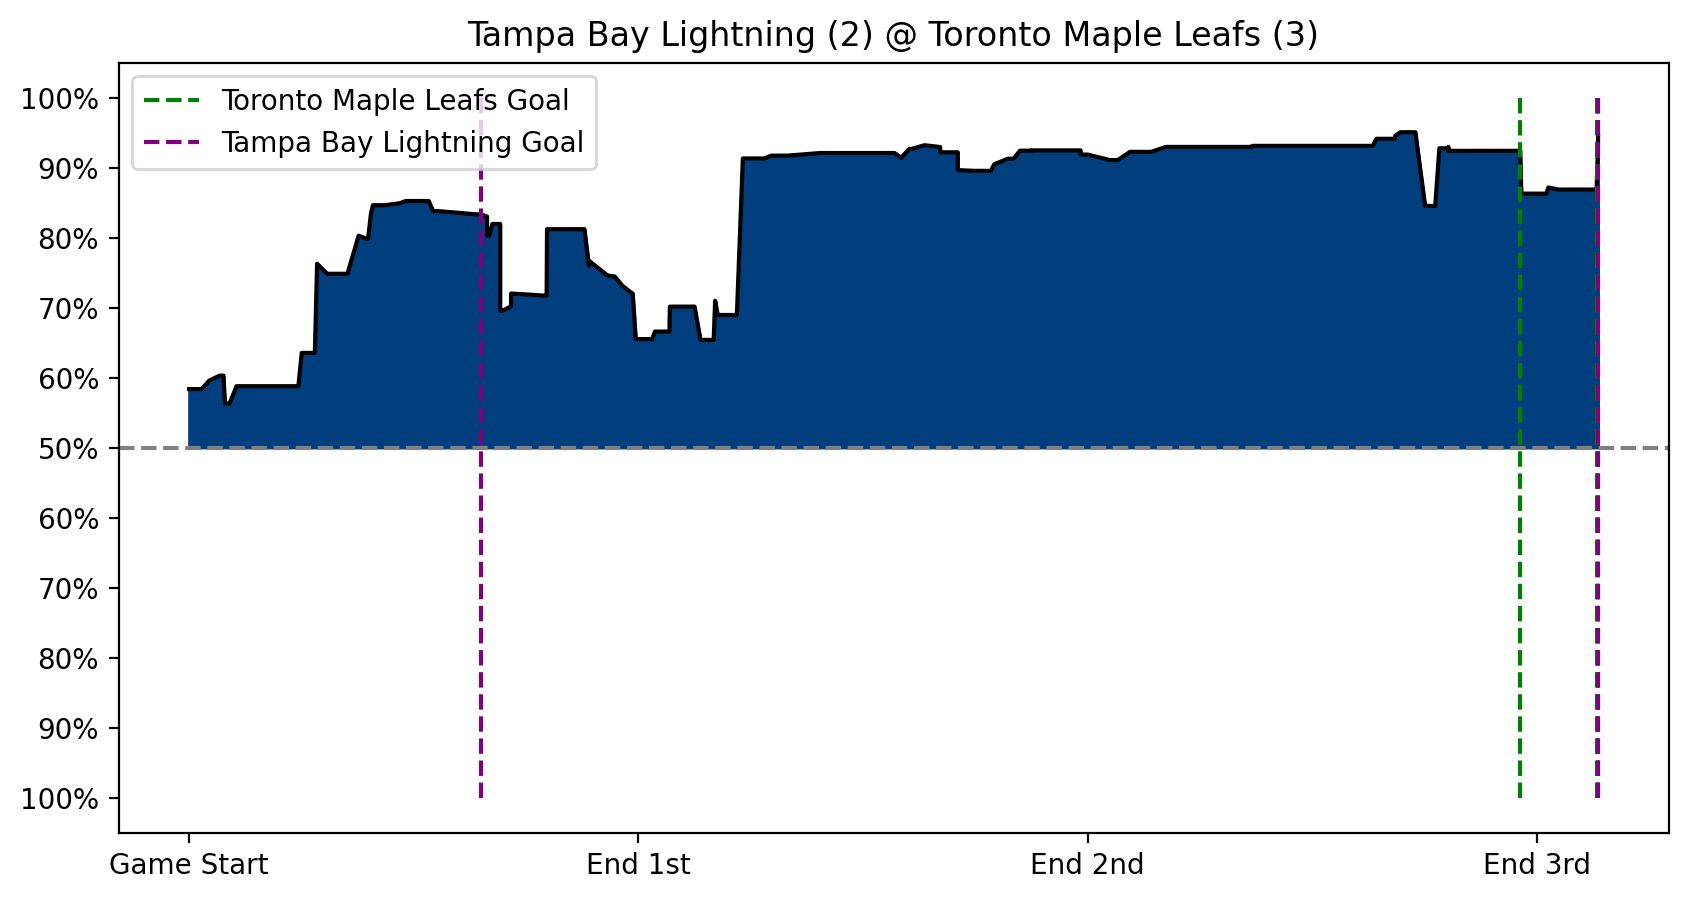

In [281]:
# Get a unique game id
game_id = np.random.choice(df_team_one['game_id'].unique())

# Get the game data
game_data = df_team_one[df_team_one['game_id'] == game_id]
team, opp = game_data['team'].values[0], game_data['opp'].values[0]

# Get who the home team is
home_team = team if game_data['is_home'].values[0] == 1 else opp
away_team = opp if game_data['is_home'].values[0] == 1 else team

# Get colors for home and away team
home_color = team_colors[home_team]
away_color = team_colors[away_team]

X = game_data.drop(columns=['game_id', 'team', 'win', 'opp'])

# Predict the win probability
y_pred = model.predict_proba(X)

# Plot the probability of the second team winning
time_vals = game_data.game_seconds
pred_vals = y_pred[:, 1] if home_team == team else y_pred[:, 0]

# Set threshold
threshold = 0.5

# Plot the probabilities
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(time_vals, pred_vals, color='black')

home_where = pred_vals >= threshold if home_team == team else pred_vals < threshold
away_where = pred_vals < threshold if home_team == team else pred_vals >= threshold

# Fill area above 50% with blue for Home Team
plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals >= threshold, color=home_color['main'], interpolate=True)

# Fill area below 50% with red for Home Team
plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals < threshold, color=away_color['main'], interpolate=True)

# Add a dotted horizontal line at y = 0.5
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.yticks(ticks=[0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], labels=['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

# Plot when the goal was scored
team_goals = game_data[game_data.curr_goals.shift(-1) != game_data.curr_goals]['game_seconds']
opp_goals = game_data[game_data.curr_opponent_goals.shift(-1) != game_data.curr_opponent_goals]['game_seconds']
home_goals = team_goals if home_team == team else opp_goals
away_goals = team_goals if home_team == opp else opp_goals
plt.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
plt.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

# Plot periods
# plt.vlines([1200, 2400, 3600], 0, 1, color='black', linestyle='-', label='Period End')
plt.xticks(ticks=[0, 1200, 2400, 3600], labels=['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
plt.title(f'{away_team} ({len(away_goals)}) @ {home_team} ({len(home_goals)})')
plt.legend()


# Show plot
plt.show()
